 # 1. Generate MESH and INCON files
 In this notebook, we assume that the mesh has already been generated by a third-party software (here Gmsh via `pygmsh`, see notebook "0. Generate mesh in Python with Gmsh").

 First, we import `numpy` and `toughio`.

In [1]:
import numpy
import toughio


 A supported mesh can be read using the function `toughio.read_mesh` that returns a `toughio.Mesh` object.

In [2]:
mesh = toughio.read_mesh("mesh.msh")


 The mesh used in this sample problem is 2D and has been defined in the XY plane, but the points have 3D coordinates (with zeros as 3rd dimension for every cells). To make it 3D in the XZ plane, we swap the 2nd and 3rd dimensions, and then extrude the mesh by 1 meter along the Y axis (2nd dimension).

In [3]:
mesh.points[:, [1, 2]] = mesh.points[:, [2, 1]]
mesh.extrude_to_3d(height=1.0, axis=1)


 (Optional) Before going any further, it is good practice to first check the quality of the mesh generated.
 TOUGH does not use any geometrical coordinate system and assumes that the line connecting a cell with its neighbor is orthogonal to their common interface. `toughio` provides a mesh property that measures the quality of a cell as the average absolute cosine angle between the line connecting a cell with its neighbor and the normal vector of the common interface.
 The mesh used in this example is of rather good quality. Bad quality cells are located at the boundaries of the model and mostly belong to the material `"BOUND"`. As this material is only used to impose Dirichlet boundary conditions in TOUGH, these bad quality cells will not impact the simulation outputs.

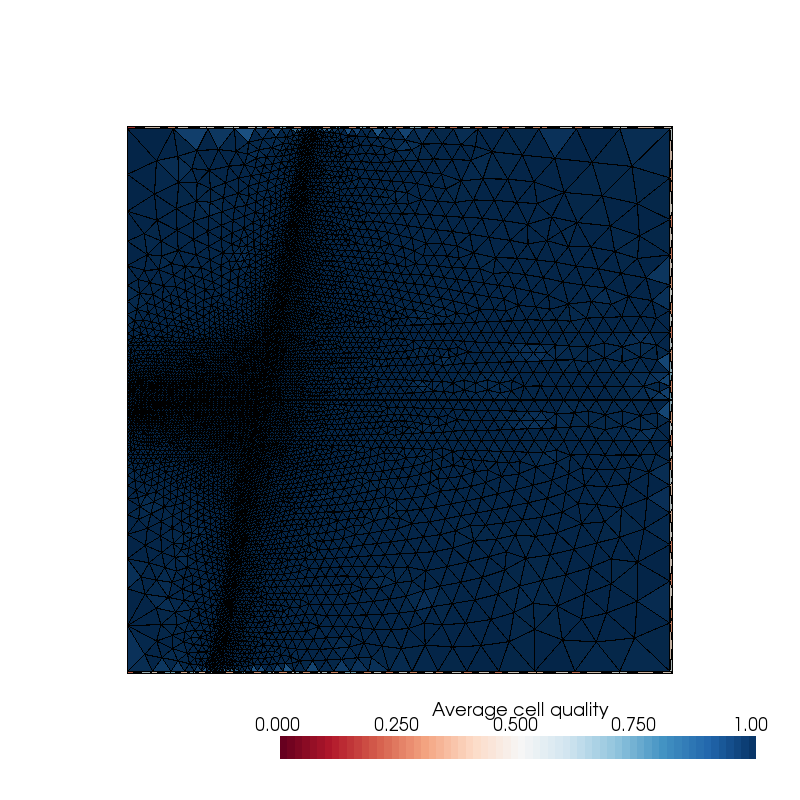

In [4]:
import pyvista
pyvista.set_plot_theme("document")

p = pyvista.Plotter(window_size=(800, 800), notebook=True)
p.add_mesh(
    mesh=mesh.to_pyvista(),
    scalars=mesh.qualities,
    stitle="Average cell quality",
    clim=(0.0, 1.0),
    cmap="RdBu",
    show_scalar_bar=True,
    show_edges=True,
)
p.view_xz()
p.show()


 (Optional) Usually, a simple distribution plot is enough to rapidly assess the quality of a mesh.

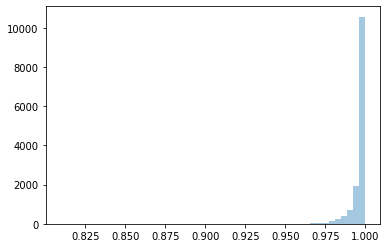

In [6]:
import seaborn

ax = seaborn.distplot(mesh.qualities[mesh.materials != "BOUND"], kde=False)


 We start by defining the boundary conditions. `toughio` recognizes the cell data key `"boundary_condition"` and automatically imposes Dirichlet boundary conditions to cells that have any value other than 0 in this cell data array.
 In this example, we simply set 1 to cells that belong to the group `"BOUND"` and 0 to others.

In [7]:
materials = mesh.materials
bcond = (materials == "BOUND").astype(int)
mesh.add_cell_data("boundary_condition", bcond)


 Initial conditions can be defined as a cell data array associated to key `"initial_condition"` where each column of the array corresponds to a primary variable. Note that `toughio` will not write any initial condition value that is lower than the threshold flag -1.0e9.

In [8]:
centers = mesh.centers
incon = numpy.full((mesh.n_cells, 4), -1.0e9)
incon[:, 0] = 1.0e5 - 9810.0 * centers[:, 2]
incon[:, 1] = 0.05
incon[:, 2] = 0.0
incon[:, 3] = 10.0 - 0.025 * centers[:, 2]
mesh.add_cell_data("initial_condition", incon)


 `toughio` also recognizes the cell data keys `"porosity"` and `"permeability"` in case we want to initialize porosity and/or permeability fields (e.g. if well logs data are available). Like boundary and initial conditions, we only have to associate new cell data arrays to keys `"porosity"` and/or `"permeability"`. The way these arrays are generated does not matter, they can be the results of simple interpolations (e.g. with `scipy`) or more advanced geostatistical interpolations (e.g. with `pykrige`).

 We can now write the `MESH` and `INCON` files by calling the method `write_tough`.
 Additionally, we can also pickle the final mesh for later use (reading a pickle file is much faster than reading any mesh format).

In [9]:
mesh.write_tough("MESH", incon=True)
mesh.write("mesh.pickle")
